In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from fancyimpute import IterativeImputer
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# read data:
data_dir = 'Data/train.csv'
data = pd.read_csv(data_dir, header = 0);
display(data.head(5))
data.drop(columns=['Name', 'PassengerId'], inplace=True)
display(data.shape)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


(8693, 12)

In [3]:
display(pd.DataFrame(data.count()).transpose())
# data.dropna(axis=0, inplace=True)
# display(pd.DataFrame(data.count()).transpose())



,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,8492,8476,8494,8511,8514,8490,8512,8510,8485,8510,8505,8693


In [4]:
# break Cabin into three categorical variables:
data['CabinDeck'] = data['Cabin'].str.extract(r'^(\S)/.*')
data['CabinNum'] = data['Cabin'].str.extract(r'.*/(\d+)/.*')
data['CabinSide'] = data['Cabin'].str.extract(r'.*/(\S)$')

categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck', 'CabinNum', 'CabinSide', 'VIP']

for var in categorical_columns:
    crosstab = pd.crosstab(data[var], data['Transported']).transpose()
    display(crosstab)
    display(chi2_contingency(crosstab).pvalue)
    

HomePlanet,Earth,Europa,Mars
Transported,,,
False,2651,727,839
True,1951,1404,920


2.809059985251311e-71

CryoSleep,False,True
Transported,,
False,3650,554
True,1789,2483


0.0

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Transported,,,
False,702,395,3128
True,1098,401,2787


7.892901466137099e-24

CabinDeck,A,B,C,D,E,F,G,T
Transported,,,,,,,,
False,129,207,239,271,563,1565,1238,4
True,127,572,508,207,313,1229,1321,1


1.0743307258871414e-80

CabinNum,0,1,10,100,1000,1001,1002,1003,1004,1005,...,990,991,992,993,994,995,996,997,998,999
Transported,,,,,,,,,,,,,,,,,,,,,
False,12,5,6,5,3,1,2,1,0,0,...,2,1,2,1,2,1,0,2,3,1
True,6,10,6,7,3,2,4,1,3,2,...,1,4,1,1,5,2,1,0,1,5


0.0018055974346714606

CabinSide,P,S
Transported,,
False,2308,1908
True,1898,2380


1.3940936254458288e-21

VIP,False,True
Transported,,
False,4093,123
True,4198,76


0.0006804064556968345

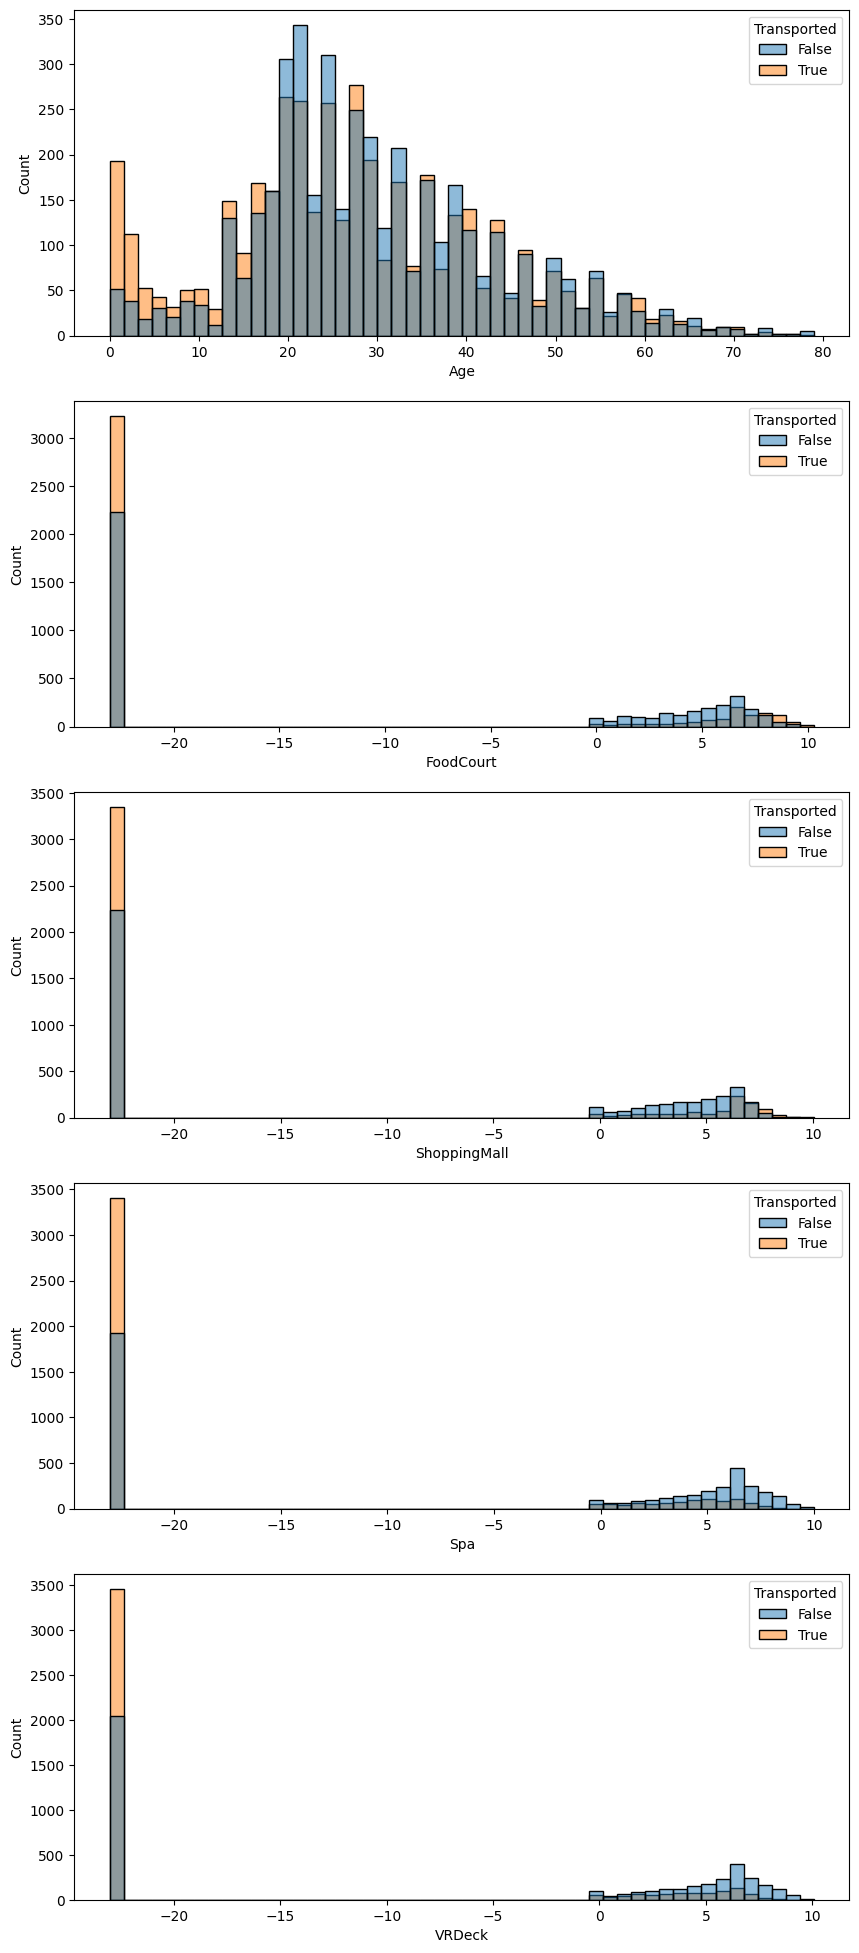

In [5]:
# generate scatter plots and histgrams:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

for i, var in enumerate(['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    if var != 'Age':
        data[var] = np.log(data[var] - data[var].min() + 1e-10)
    
    sns.histplot(data[[var, 'Transported']], x=var, hue='Transported', bins=50, ax=ax[i],)


In [6]:
# data = pd.get_dummies(data, columns=['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinSide', 'Destination', 'VIP'], drop_first=True)
data.drop(columns=['Cabin', 'CabinNum'], inplace=True);
label_encoder = LabelEncoder()

for var in categorical_columns:
    if var in data:
        data[var] = label_encoder.fit_transform(data[var])
        

In [ ]:
# train random forest model:

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Transported']),
    data['Transported'],
    test_size=0.2,
    random_state=42
)

imputer = IterativeImputer(max_iter=100, tol=1e-3, random_state=0)  # You can adjust parameters
# Fit the imputer to the data and transform the data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(np.isnan(X_train).sum(axis=0))

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


[0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
nan_counts = np.sum(np.isnan(X_train), axis=0)
nan_counts

In [ ]:

def preprocess(data):
    data.drop(columns=['Name', 'PassengerId'], inplace=True)
    # data.dropna(axis=0, inplace=True)

    # break Cabin into three categorical variables:
    data['CabinDeck'] = data['Cabin'].str.extract(r'^(\S)/.*')
    data['CabinNum'] = data['Cabin'].str.extract(r'.*/(\d+)/.*')
    data['CabinSide'] = data['Cabin'].str.extract(r'.*/(\S)$')

    for var in categorical_columns:
        data[var] = label_encoder.fit_transform(data[var])

    for var in ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        data[var] = np.log(data[var] - data[var].min() + 1e-10)

    # data = pd.get_dummies(data, columns=['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinSide', 'Destination', 'VIP'], drop_first=True)
    data.drop(columns=['Cabin', 'CabinNum'], inplace=True)
    # x = data.fillna(0)
    x = imputer.transform(data)

    return x

data_test = pd.read_csv('Data/test.csv', header=0)
passenger = data_test['PassengerId']
x_test = preprocess(data_test)
y_pred = best_model.predict(x_test)



In [ ]:
data_prediction = pd.DataFrame({'PassengerId': passenger, 'Transported': y_pred})

In [ ]:
data_prediction.to_csv('Data/predictions_rf.csv', index=None)